

## **Домашнее задание 7.**

### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [2]:
import PIL

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!ls ./gdrive/MyDrive

'Colab Notebooks'      molecular_modeling   simpsons.zip
 Data		       Notability	    Topic.gdoc
 journey-springfield   QR_illness.pdf	   'Таблица 1.2.5.gsheet'


In [5]:
!unzip ./gdrive/MyDrive/simpsons.zip -d simpsons

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: simpsons/train/simpsons_dataset/moe_szyslak/pic_1037.jp

In [6]:
!nvidia-smi

Mon Apr 11 18:27:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


Использование датасета из картинок - дело не самое простое, на будущее для себя последовательность действий:

1) Создать итератор из всех файлов (объектов Path)

Из этого итератора мы теперь строим Dataset, то есть надо наследоваться от torch.utils.Dataset, чтобы писать wrapper либо как-то подстраиваться под уже существующий.

2) Из названий картинок считать метки классов, а сами картинки переделать в torch.tensor и здесь же применить нормализацию с $\mu$ и $\sigma$, которые возьмем с модели, обученной на ImageNet. Здесь же аугментируем данные. Создание Dataset - самое важное, потому что в DataLoader мы просто его делим на батчи и шаффлим, а именно в нашем классе датасета происходят все необходимые трансформации.



In [8]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [39]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]     # извлекаем все возможные классы из названий картинок
            self.label_encoder.fit(self.labels)     # лейбл энкодер фитим на этих названиях классов

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)     # функция, позволяющая записывать объект в файл
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # Датасет у нас хранится в виде некоторых картинок, но как только мы достаем из него элемент с ним делается __getitem__
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('./simpsons/train/simpsons_dataset')
TEST_DIR = Path('./simpsons/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))    # рекурсивно собирает все файлы из указанной директории формата jpg
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [13]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

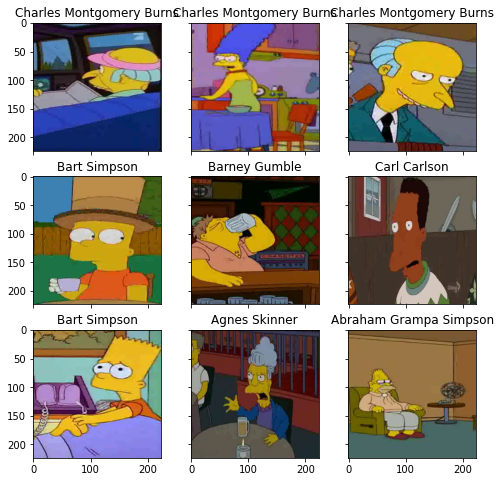

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

### Построение нейросети
Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [15]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # FC слой:
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) 
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)   # при конкатенации сохраняем dim, который отвечает за размер батча - 
                                    # получаем batch_size картинок выпрямленных в векторы, которые пассаем в FC
        logits = self.out(x)
        return logits

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    '''
    Функция обучения по всем батчам 1 раз (1 эпоха)
    '''
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [18]:
def train(train_data, val_data, model, epochs, batch_size):
    '''
    Полный цикл обучения
    '''
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [20]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
simple_cnn

we will classify :42


SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_features=42, bias=True)


Запустим обучение сети.

In [21]:
# Надо отдельными датасетами создавать для val и для train, потому что иначе будет утечка данных из-за трансформаций внутри методов класса

if val_dataset is None:     # Мы уже ранее создали его, чтобы на картиночки посмотреть
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')      # Loader уже внутри train цикла создается

In [22]:
# history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.571967155259539


epoch:  50%|█████     | 1/2 [02:56<02:55, 176.00s/it]


Epoch 001 train_loss: 2.5720     val_loss 1.9144 train_acc 0.2862 val_acc 0.4834
loss 1.487643063975805


epoch: 100%|██████████| 2/2 [06:05<00:00, 182.93s/it]


Epoch 002 train_loss: 1.4876     val_loss 1.2469 train_acc 0.5925 val_acc 0.6771


Построим кривые обучения

In [23]:
loss, acc, val_loss, val_acc = zip(*history)

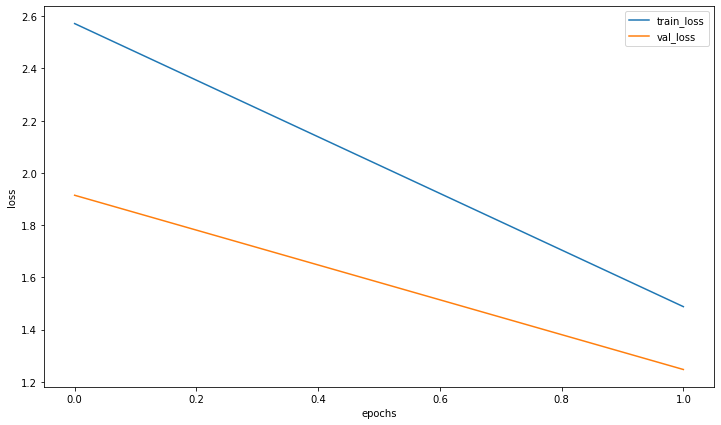

In [24]:
plt.figure(figsize=(12, 7))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

<img src="https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg" width="300">

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [25]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [26]:
# Берем рандомную картинку
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [50]:
# Посмотрим качество на всей валидационной выборке:
imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]

probs_ims = predict(simple_cnn, imgs)

In [51]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [53]:
y_pred = np.argmax(probs_ims, -1)

actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [56]:
from sklearn.metrics import f1_score

# macro average - просто среднее f1 скоров по всем классам (у каждого класса локальные TP и FN)
# micro average - TP и FN общие для всех классов - и потом на этих TP и FN определяем f1 скор
  
f1_score(actual_labels, y_pred, average='micro')

0.6771111960259839

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

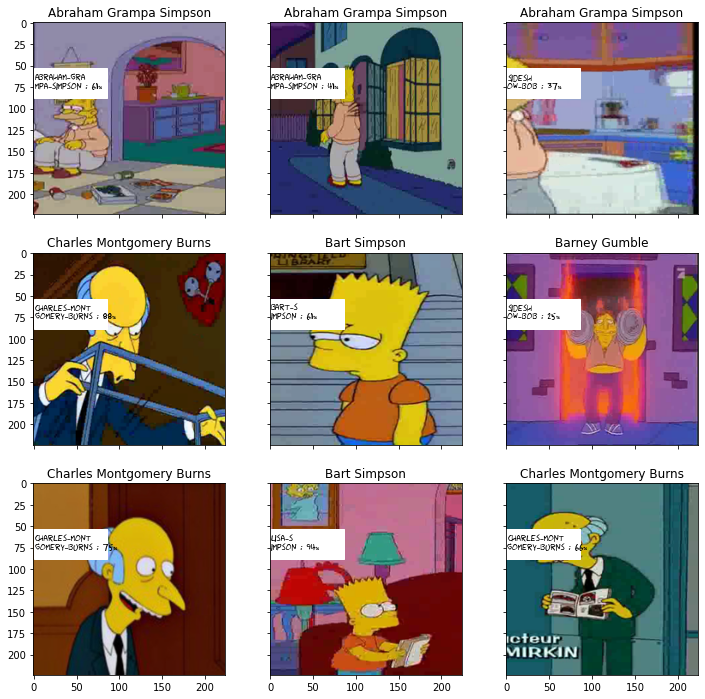

In [57]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

In [32]:
# Делаем итоговое предсказание на тестовой (неразмеченной выборке)
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))   # инверсивно трансформим из цифорок классов в string
test_filenames = [path.name for path in test_dataset.files]


In [33]:
import pandas as pd
my_submit = pd.read_csv("./simpsons/sample_submission.csv")

my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [34]:
my_submit['Expected'] = preds

In [35]:
my_submit.to_csv('./my_CV_submission.csv', index=False)

Несколько улучшений для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

---

## **Стадия вторая:**

Оставлю ту же модель, но добавлю батч нормы, буду делить на батчи поменьше, использую lr scheduler и немного настрою Adam. (добавлю L2 рег)

Погнали:

Для начала надо модифицировать функции для обучения сетки:

In [48]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [78]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    '''
    Функция обучения по всем батчам 1 раз (1 эпоха)
    '''
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [79]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [81]:
def train(train_data, val_data, model, optimizer, scheduler, epochs, batch_size):
    '''
    Полный цикл обучения
    '''
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [82]:
class BetterCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=96)
        )
        # FC слой - я просто решил добавить один скрытый слой, авось не переобучится:
        self.out = nn.Sequential(
            nn.Linear(96 * 5 * 5, 96 * 5 * 5),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(96 * 5 * 5, n_classes),
        )
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) 
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)   # при конкатенации сохраняем dim, который отвечает за размер батча - 
                                    # получаем batch_size картинок выпрямленных в векторы, которые пассаем в FC
        logits = self.out(x)
        return logits

In [83]:
def get_f1_of_validation(model):

    imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]
    probs_ims = predict(model, imgs)        # predict - нам написанная функция (она софтмакс к выходам применяет)
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    y_pred = np.argmax(probs_ims, -1)

    actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]
    preds_class = [label_encoder.classes_[i] for i in y_pred]

    return f1_score(actual_labels, y_pred, average='micro')

In [73]:
get_f1_of_validation(simple_cnn)

0.6771111960259839

In [1]:
import torch.optim as optim
from torch.optim import lr_scheduler

better_model = BetterCnn(n_classes).to(DEVICE)
optimizer = optim.Adam(better_model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=0.01)
# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler (кстати в 7 семинаре тоже была эта ошибка допущена)
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

NameError: ignored

In [ ]:
history = train(train_data=train_dataset, val_data=val_dataset, model=better_model, epochs=10, batch_size=8, scheduler=exp_scheduler, optimizer=optimizer)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 5.248121646872234


epoch:  10%|█         | 1/10 [03:59<35:57, 239.78s/it]


Epoch 001 train_loss: 5.2481     val_loss 2.6416 train_acc 0.1945 val_acc 0.2797
loss 3.1609592651575187


epoch:  20%|██        | 2/10 [07:34<29:58, 224.87s/it]


Epoch 002 train_loss: 3.1610     val_loss 3.1479 train_acc 0.0999 val_acc 0.0617
loss 493765.87459086574


epoch:  30%|███       | 3/10 [11:03<25:23, 217.71s/it]


Epoch 003 train_loss: 493765.8746     val_loss 57193.1647 train_acc 0.0892 val_acc 0.0695
loss 2249.7845124380096


epoch:  40%|████      | 4/10 [14:23<21:03, 210.65s/it]


Epoch 004 train_loss: 2249.7845     val_loss 3.1999 train_acc 0.1069 val_acc 0.1074


In [ ]:
torch.save(better_model.state_dict(), 'Better_model.pth')